<a href="https://colab.research.google.com/github/connor-verheyen/COVID19_IndoorRH/blob/main/supplementary_analysis/Supplementary_Section_03__Analyzing_Outdoor_Weather_Variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries 
import pandas as pd
import numpy as np
import scipy as sp 
import math
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
import matplotlib.dates as md

In [ ]:
# For a specific version of seaborn package 
!pip install seaborn==0.10.1

     |████████████████████████████████| 215 kB 4.5 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [ ]:
# Set seaborn plotting style 
sns.set(context='talk', font_scale=0.9, style='ticks', palette='Blues_d')

In [ ]:
# Import Files 
filename='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/7DaySmooth_ALLVars_Dataset_2020_08_10_GE50_Deaths.csv'

df7all = pd.read_csv(filename) #df7all = pd.read_excel('7DaySmooth_ALLVars_Dataset_2020_08_10_GE50_Deaths.xlsx')

# Drop unnecessary index columns 
df7all.drop(columns='Unnamed: 0',axis=1,inplace=True)

In [ ]:
# Tropic of Cancer is located at 23.5 degrees north of the equator and runs through Mexico, the Bahamas, Egypt, Saudi Arabia, India, and southern China
# The Tropic of Capricorn lies at 23.5 degrees south of the equator and runs through Australia, Chile, southern Brazil, and northern South Africa
upper_lat_bound = 23.5; lower_lat_bound = -23.5 
n_hem = df7all[df7all['Lat']>upper_lat_bound]; s_hem = df7all[df7all['Lat']<lower_lat_bound]; trop  = df7all[(df7all['Lat']<upper_lat_bound) & (df7all['Lat']>lower_lat_bound)]

print('Total Country Count:',df7all['Country'].unique().shape[0])
print('Northern Hemisphere Country Count:',n_hem['Country'].unique().shape[0])
print('Southern Hemisphere Country Count:',s_hem['Country'].unique().shape[0])
print('Tropics Country Count:',trop['Country'].unique().shape[0])

Total Country Count: 121
Northern Hemisphere Country Count: 67
Southern Hemisphere Country Count: 4
Tropics Country Count: 50


In [ ]:
# Assign the region name to each country in the dataset 
# df.loc[:,'Region'] = ['n_hem' if country_name in n_hem['Country'].unique() else # assigned n_hem if its in the list of northern hemisphere countries 
#                       's_hem' if country_name in s_hem['Country'].unique() else # assigned s_hem if its in the list of southern hemisphere countries 
#                       'trop' # assigned tropical if its neither northern or southern hemisphere 
#                       for country_name in df.loc[:,'Country']]
df7all.loc[:,'Region'] = ['n_hem' if country_name in n_hem['Country'].unique() else 's_hem' if country_name in s_hem['Country'].unique() else 'trop' for country_name in df7all.loc[:,'Country']]

In [ ]:
# List of other weather variables to look at... 
other_weather_vars = ['DailyTemp_C', 'Daily_UV', 'DailyRH_pct', 'DailyAH_gperm3']

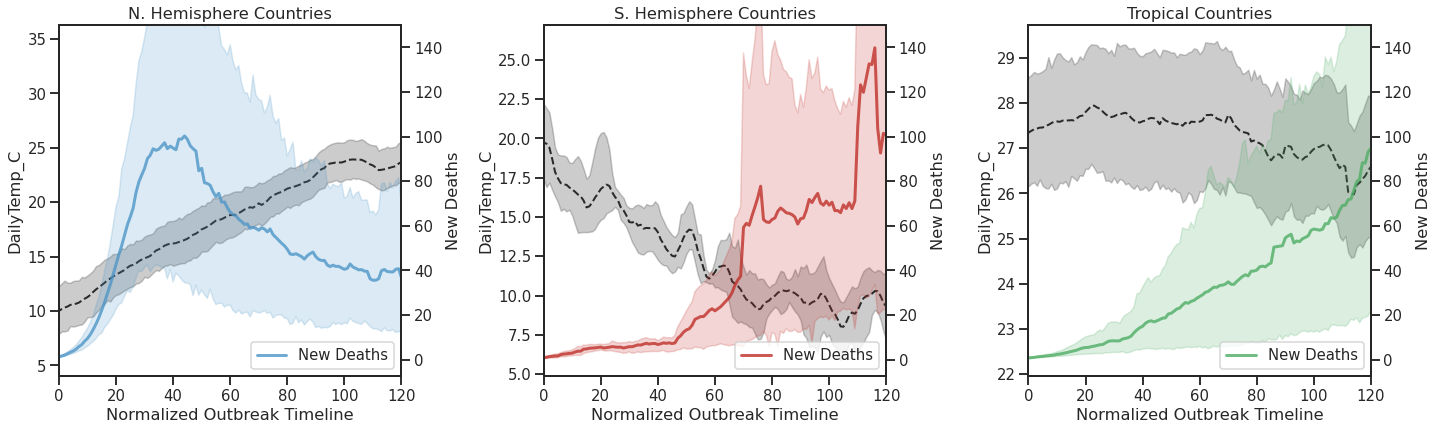

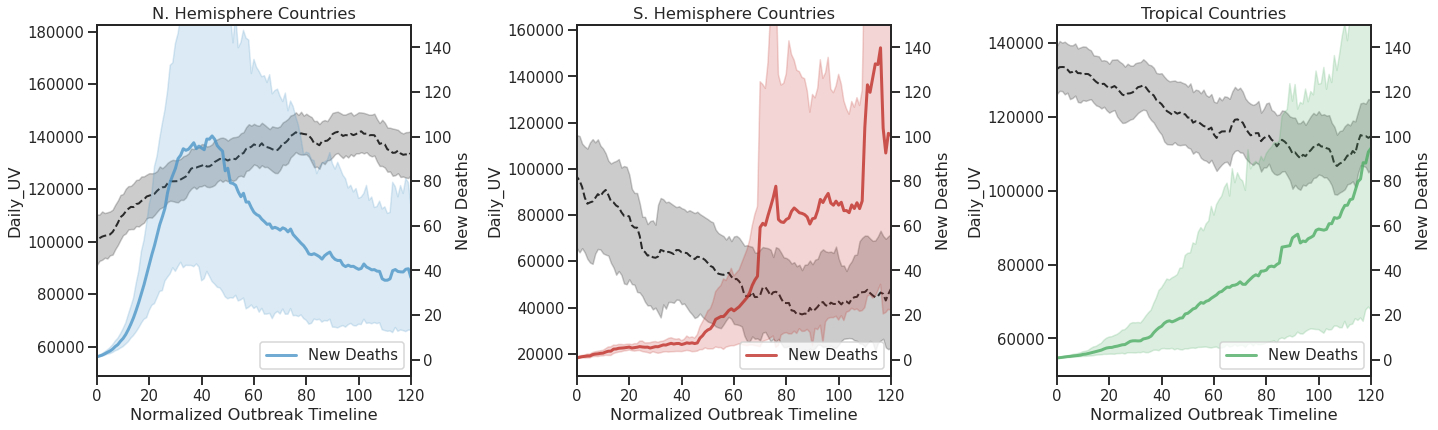

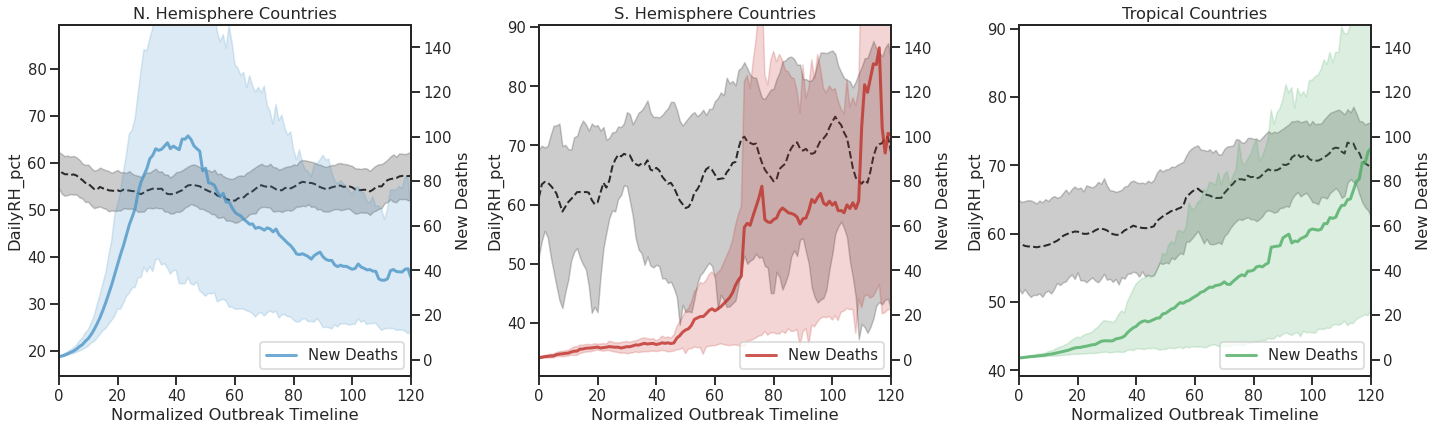

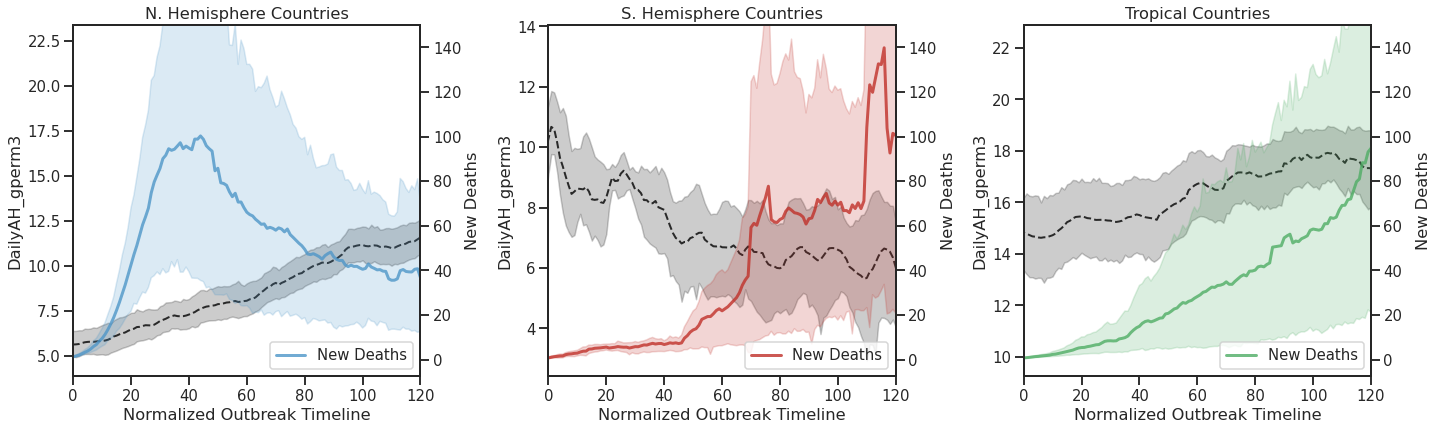

In [ ]:
for variable in other_weather_vars: 

  fig,ax = plt.subplots(1,3,figsize=(20,6))

  # N. Hemisphere 
  ax0 = ax[0].twinx()
  sns.lineplot(x='Days From 5th Death',y=variable,data=df7all[df7all['Region']=='n_hem'],ax=ax[0],color='black',linewidth=2,alpha=0.8)#,style=True,dashes=[(2,2)])
  sns.lineplot(x='Days From 5th Death',y='new_deaths',data=df7all[df7all['Region']=='n_hem'],ax=ax0,label='New Deaths',color=sns.color_palette(palette='Blues_d',n_colors=4)[1],linewidth=3,alpha=0.8)
  #ax[0].set_ylim(20,80)
  ax0.set_ylim(-7.5,150)
  #ax[0].legend(loc='upper left')
  ax0.legend(loc='lower right')
  ax[0].lines[0].set_linestyle("--")

  # S. Hemisphere 
  ax1 = ax[1].twinx()
  sns.lineplot(x='Days From 5th Death',y=variable,data=df7all[df7all['Region']=='s_hem'],ax=ax[1],color='black',linewidth=2,alpha=0.8)
  sns.lineplot(x='Days From 5th Death',y='new_deaths',data=df7all[df7all['Region']=='s_hem'],ax=ax1,label='New Deaths',color=sns.color_palette(palette='Reds_d',n_colors=4)[2],linewidth=3,alpha=0.8)
  #ax[1].set_ylim(20,80)
  ax1.set_ylim(-7.5,150)
  #ax[1].legend(loc='upper left')
  ax1.legend(loc='lower right')
  ax[1].lines[0].set_linestyle("--")

  # Trop
  ax2 = ax[2].twinx()
  sns.lineplot(x='Days From 5th Death',y=variable,data=df7all[df7all['Region']=='trop'],ax=ax[2],color='black',linewidth=2,alpha=0.8)
  sns.lineplot(x='Days From 5th Death',y='new_deaths',data=df7all[df7all['Region']=='trop'],ax=ax2,label='New Deaths',color=sns.color_palette(palette='Greens_d',n_colors=4)[1],linewidth=3,alpha=0.8)
  #ax[2].set_ylim(20,80)
  ax2.set_ylim(-7.5,150)
  #ax[2].legend(loc='upper left')
  ax2.legend(loc='lower right')
  ax[2].lines[0].set_linestyle("--")


  # Labels & Titles 
  ax[0].set_title('N. Hemisphere Countries'); ax[1].set_title('S. Hemisphere Countries'); ax[2].set_title('Tropical Countries')
  ax0.set_ylabel('New Deaths'); ax1.set_ylabel('New Deaths'); ax2.set_ylabel('New Deaths')
  [ax.set_xlabel('Normalized Outbreak Timeline') for ax in plt.gcf().axes]
  [ax.set_xlim(0,120) for ax in plt.gcf().axes]
  fig.tight_layout(pad=0.5, w_pad=1, h_pad=0.8)


In [ ]:
# Function to create lags of a given variable 

def make_lags(dataframe,merging_var,variable,num_lags):
  df = dataframe[['Country',merging_var,variable]].copy() # Make a copy of the country (for grouping) and the variable to be lagged  

  for i in range(1,num_lags+1):
    df[variable+'_lag{}'.format(i)] = df.groupby('Country')[variable].shift(i) # Create all of the lags of the given input variable 

  return df

In [ ]:
# Function to create a dataframe with lagged versions of the variable and the actual outbreak metrics 

def lagged_var_df(dataframe,merging_var,variable,num_lags,COVIDstats):

  df = dataframe.copy()

  outcomes = df[COVIDstats]

  lagged_variables = make_lags(dataframe,merging_var,variable,num_lags)

  merged = lagged_variables.merge(right=outcomes,how='left',on=['Country',merging_var])

  return merged

In [ ]:
# Create a dataframe with lagged indoor humidity (from 0 days of lag up to 28 days of lag)
COVIDstats = ['Country','Days From 5th Death','total_cases', 'total_cases_per_million', 'new_cases', # Add country and date so there can be correct merging on keys 
       'new_cases_per_million', 'total_deaths', 'total_deaths_per_million',
       'total_deaths_pctchange', 'total_deaths_per_million_pctchange',
       'new_deaths', 'new_deaths_per_million', 'new_deaths_diff',
       'new_deaths_per_million_diff', 'new_deaths_pctchange',
       'new_deaths_per_million_pctchange']

# List of other weather variables to look at... 
other_weather_vars = ['DailyTemp_C', 'Daily_UV', 'DailyRH_pct', 'DailyAH_gperm3']

# Dataframes with lagged variables 
df7all_lag_temp = lagged_var_df(df7all,'Days From 5th Death','DailyTemp_C',28,COVIDstats)
df7all_lag_uv = lagged_var_df(df7all,'Days From 5th Death','Daily_UV',28,COVIDstats)
df7all_lag_RH = lagged_var_df(df7all,'Days From 5th Death','DailyRH_pct',28,COVIDstats)
df7all_lag_AH = lagged_var_df(df7all,'Days From 5th Death','DailyAH_gperm3',28,COVIDstats)

In [ ]:
# List of lagged dataframes with other weather variables to look at... 
lagged_other_weather_vars = [df7all_lag_temp, df7all_lag_uv,df7all_lag_RH,df7all_lag_AH]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


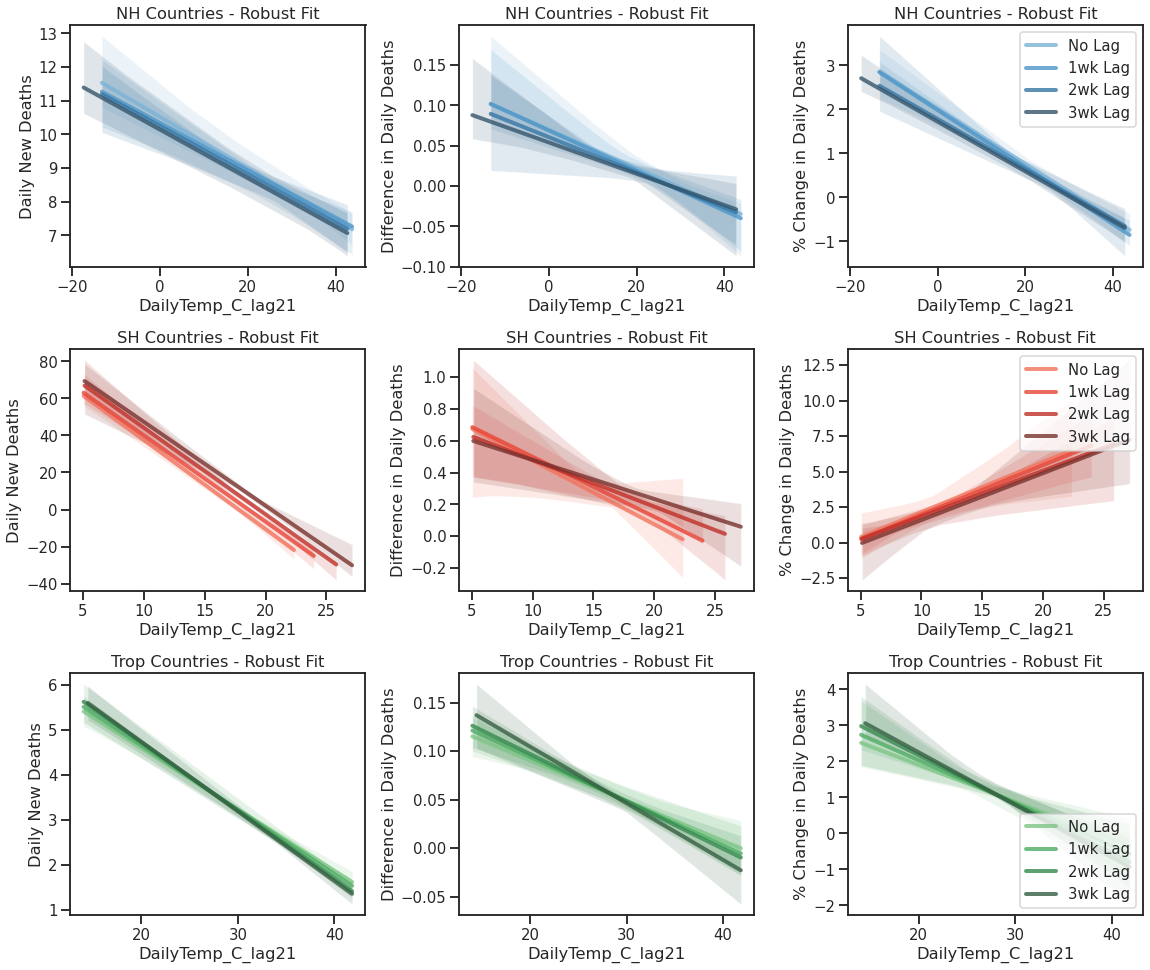

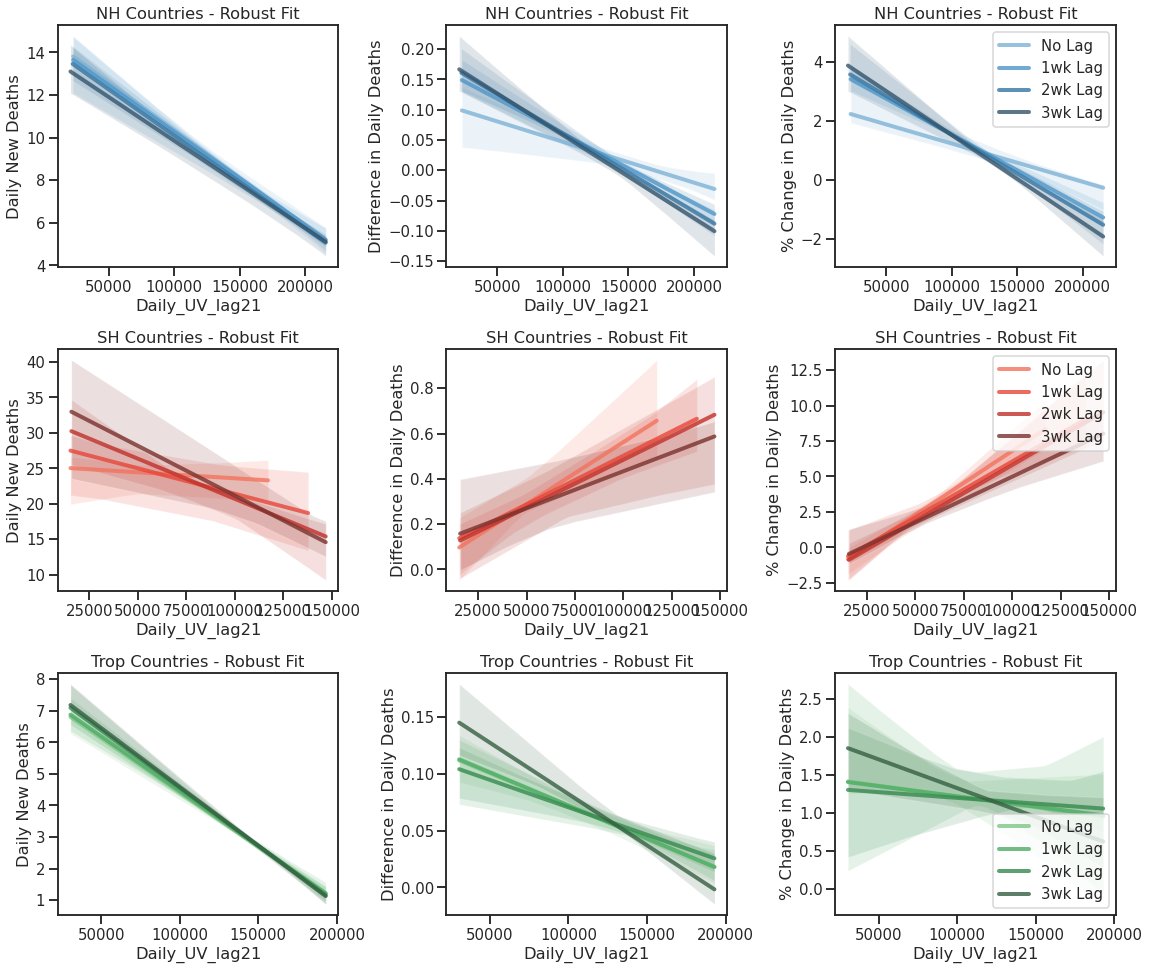

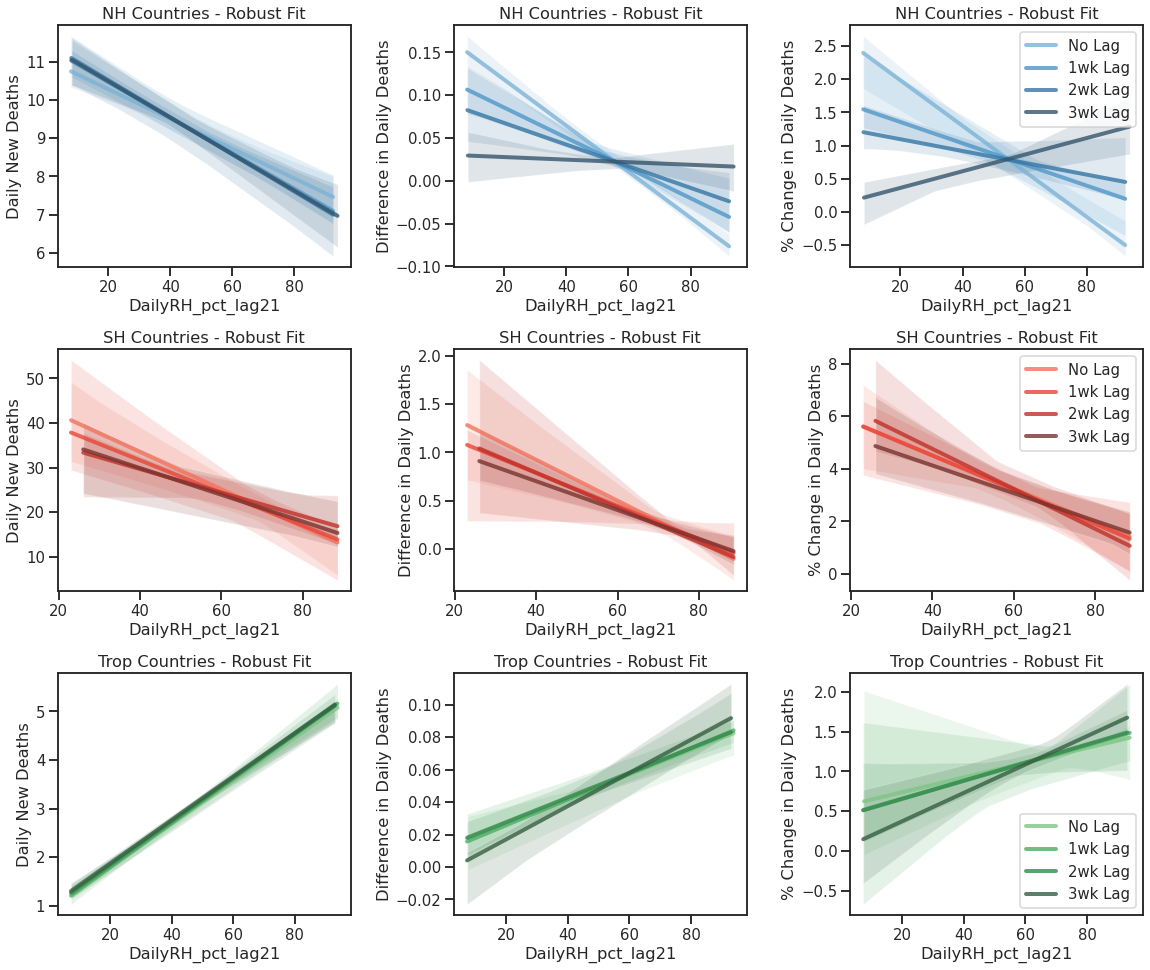

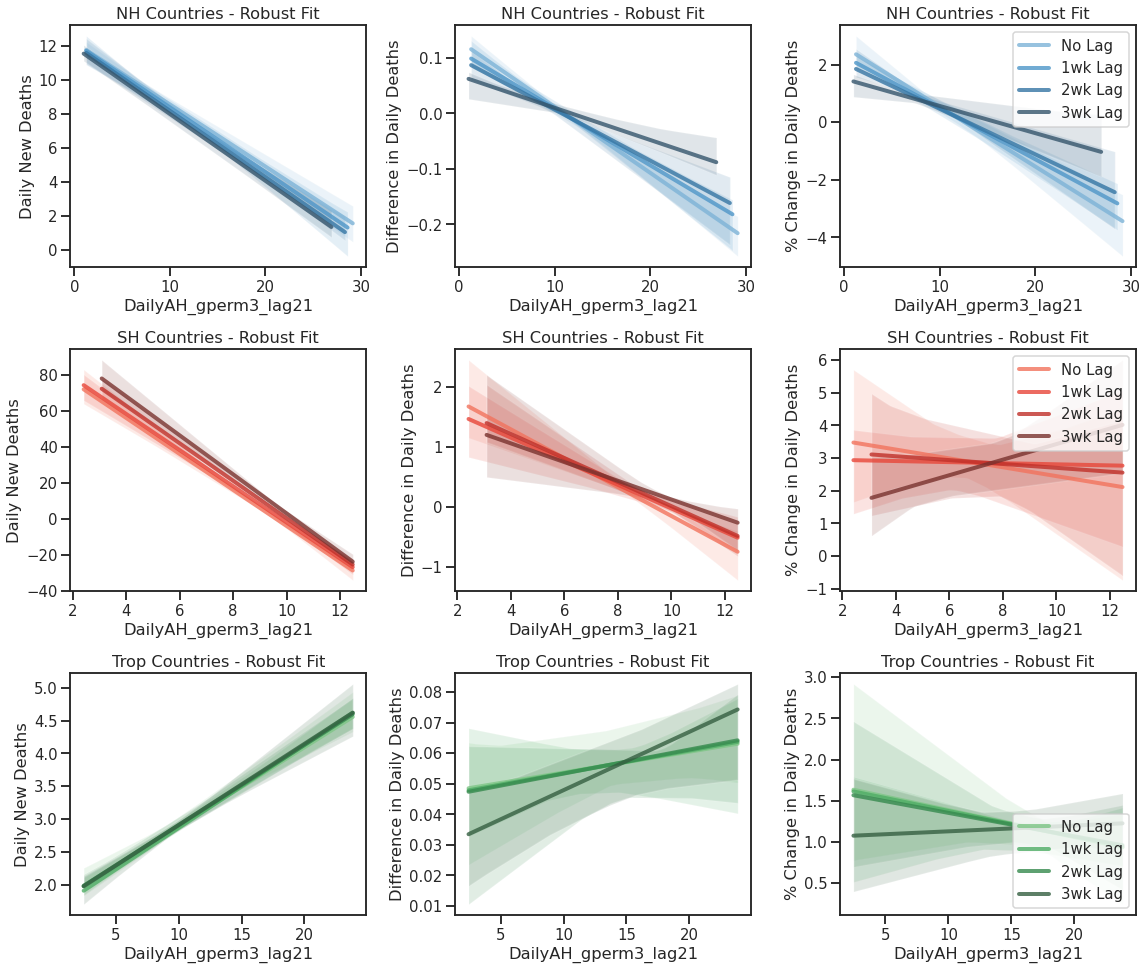

In [ ]:
for df7all_lag_VARIABLE in lagged_other_weather_vars:

  nhem_forplot = df7all_lag_VARIABLE[(df7all_lag_VARIABLE['Days From 5th Death']>=0) & (df7all_lag_VARIABLE['Days From 5th Death']<=120) & (df7all_lag_VARIABLE['Country'].isin(n_hem['Country'].unique()))]
  shem_forplot = df7all_lag_VARIABLE[(df7all_lag_VARIABLE['Days From 5th Death']>=0) & (df7all_lag_VARIABLE['Days From 5th Death']<=120) & (df7all_lag_VARIABLE['Country'].isin(s_hem['Country'].unique()))]
  trop_forplot = df7all_lag_VARIABLE[(df7all_lag_VARIABLE['Days From 5th Death']>=0) & (df7all_lag_VARIABLE['Days From 5th Death']<=120) & (df7all_lag_VARIABLE['Country'].isin(trop['Country'].unique()))]

  outcomes = ['new_deaths','new_deaths_diff','new_deaths_pctchange']
  rows = 3; cols = len(outcomes); fig,ax=plt.subplots(rows,cols,figsize=(16,13.5))

  # Go through each quantized outbreak metric and make plots 
  for col in range(0,cols): 

    # LOWESS for n hem countries 
    sns.regplot(x=df7all_lag_VARIABLE.columns[2],y=outcomes[col],data=nhem_forplot,ax=ax[0,col],robust=True,n_boot=10,label='No Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Blues_d',n_colors=4)[0])
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag7',y=outcomes[col],data=nhem_forplot,ax=ax[0,col],robust=True,n_boot=10,label='1wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Blues_d',n_colors=4)[1]) 
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag14',y=outcomes[col],data=nhem_forplot,ax=ax[0,col],robust=True,n_boot=10,label='2wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Blues_d',n_colors=4)[2])
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag21',y=outcomes[col],data=nhem_forplot,ax=ax[0,col],robust=True,n_boot=10,label='3wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Blues_d',n_colors=4)[3])

    # LOWESS for s hem countries 
    sns.regplot(x=df7all_lag_VARIABLE.columns[2],y=outcomes[col],data=shem_forplot,ax=ax[1,col],robust=True,n_boot=10,label='No Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Reds_d',n_colors=4)[0])
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag7',y=outcomes[col],data=shem_forplot,ax=ax[1,col],robust=True,n_boot=10,label='1wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Reds_d',n_colors=4)[1]) 
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag14',y=outcomes[col],data=shem_forplot,ax=ax[1,col],robust=True,n_boot=10,label='2wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Reds_d',n_colors=4)[2])
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag21',y=outcomes[col],data=shem_forplot,ax=ax[1,col],robust=True,n_boot=10,label='3wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Reds_d',n_colors=4)[3])

    # LOWESS for trop countries 
    sns.regplot(x=df7all_lag_VARIABLE.columns[2],y=outcomes[col],data=trop_forplot,ax=ax[2,col],robust=True,n_boot=10,label='No Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Greens_d',n_colors=4)[0])
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag7',y=outcomes[col],data=trop_forplot,ax=ax[2,col],robust=True,n_boot=10,label='1wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Greens_d',n_colors=4)[1]) 
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag14',y=outcomes[col],data=trop_forplot,ax=ax[2,col],robust=True,n_boot=10,label='2wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Greens_d',n_colors=4)[2])
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag21',y=outcomes[col],data=trop_forplot,ax=ax[2,col],robust=True,n_boot=10,label='3wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Greens_d',n_colors=4)[3])

  [ax[r,2].legend(loc='upper right') for r in np.arange(0,2)]; ax[2,2].legend(loc='lower right') 

  [ax[r,0].set_ylabel('Daily New Deaths') for r in np.arange(0,3)]
  [ax[r,1].set_ylabel('Difference in Daily Deaths') for r in np.arange(0,3)]
  [ax[r,2].set_ylabel('% Change in Daily Deaths') for r in np.arange(0,3)]

  ax[0,0].set_title('NH Countries - Robust Fit')
  ax[0,1].set_title('NH Countries - Robust Fit')
  ax[0,2].set_title('NH Countries - Robust Fit')

  ax[1,0].set_title('SH Countries - Robust Fit')
  ax[1,1].set_title('SH Countries - Robust Fit')
  ax[1,2].set_title('SH Countries - Robust Fit')

  ax[2,0].set_title('Trop Countries - Robust Fit')
  ax[2,1].set_title('Trop Countries - Robust Fit')
  ax[2,2].set_title('Trop Countries - Robust Fit')

  fig.tight_layout(pad=0.5,h_pad=1,w_pad=1)

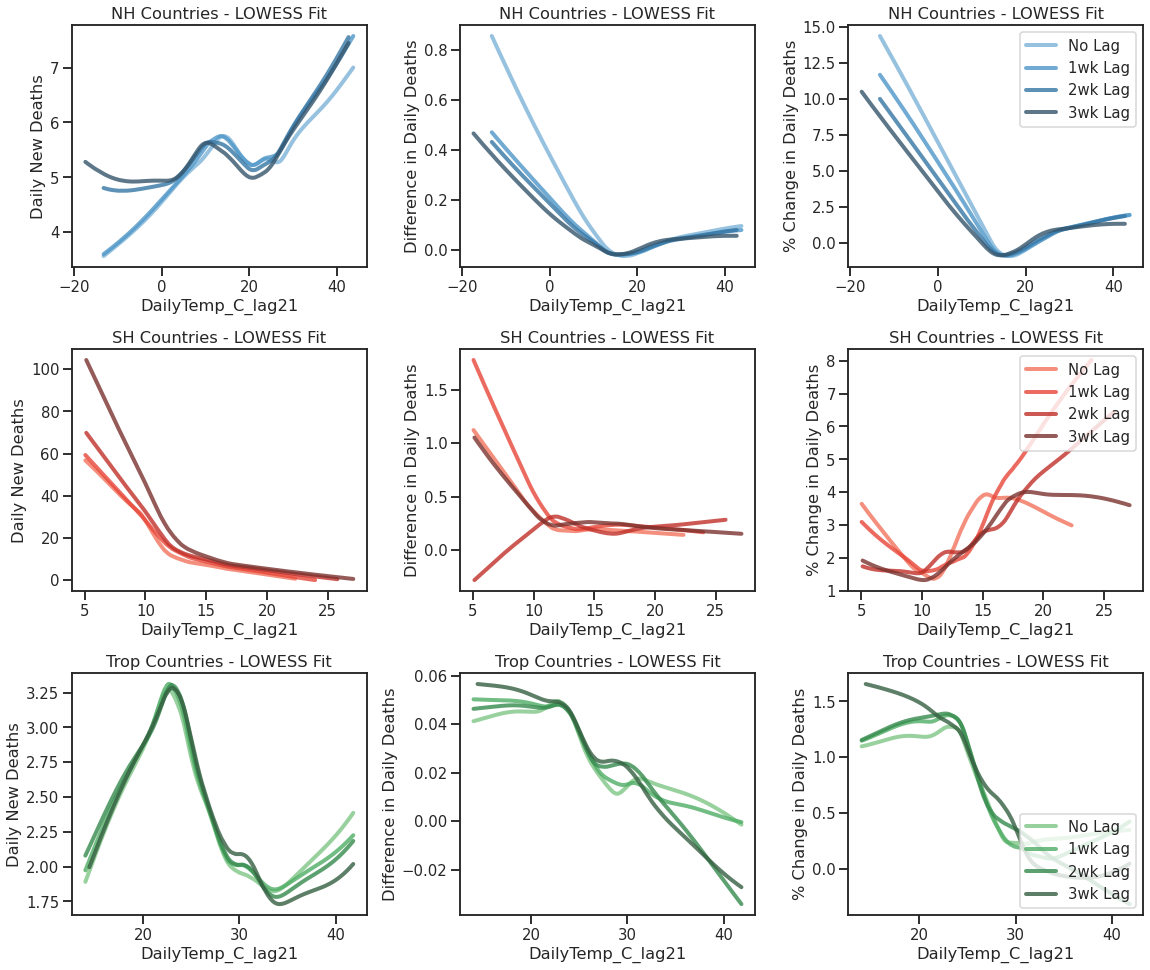

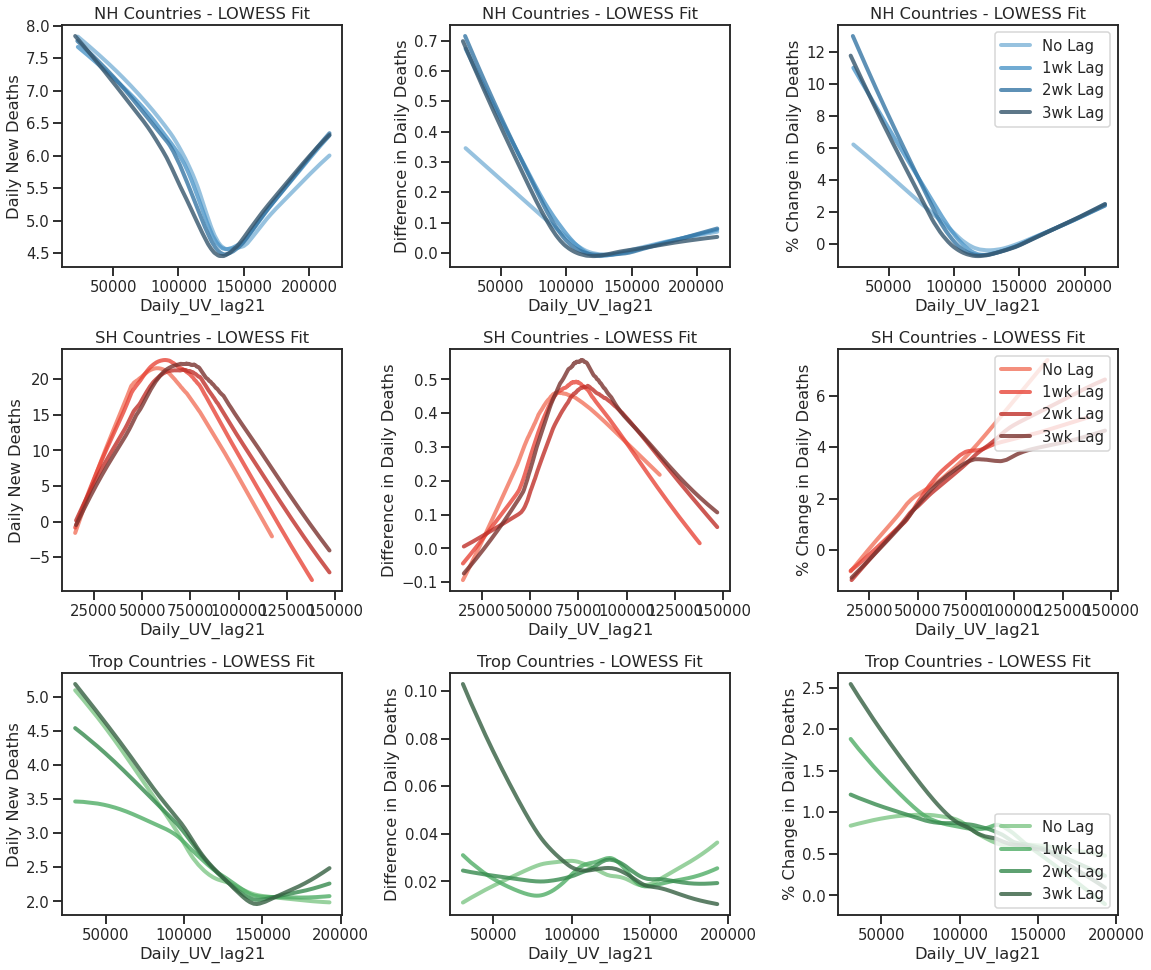

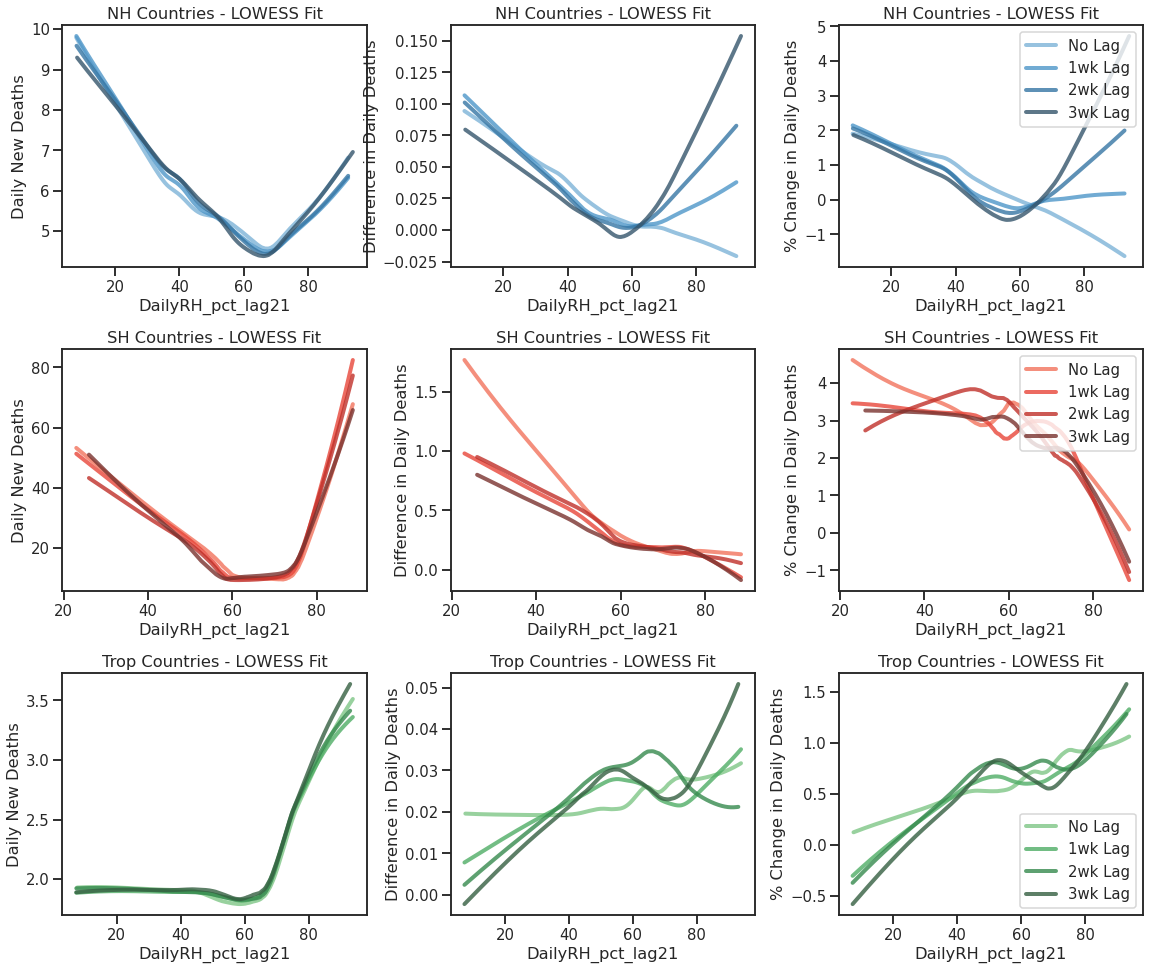

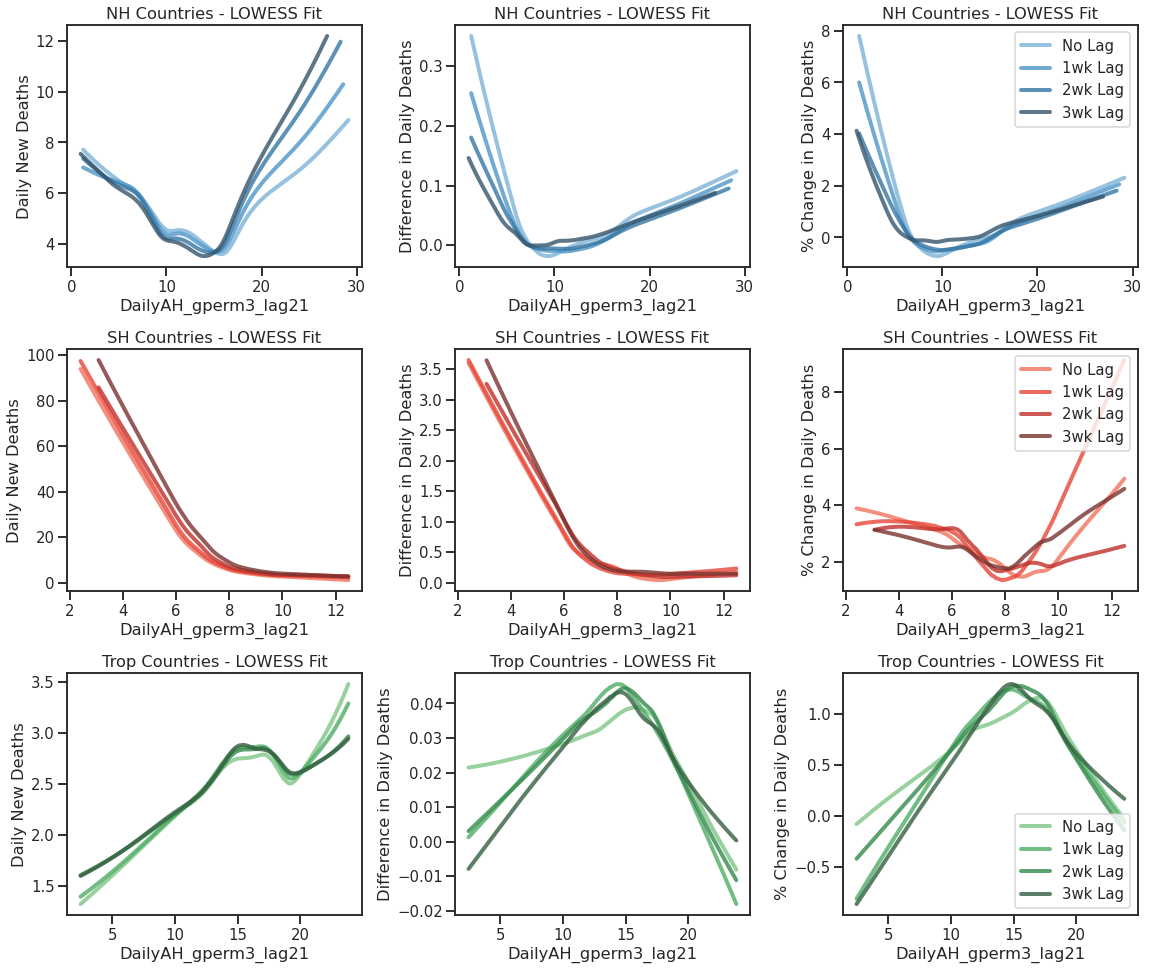

In [ ]:
for df7all_lag_VARIABLE in lagged_other_weather_vars:

  nhem_forplot = df7all_lag_VARIABLE[(df7all_lag_VARIABLE['Days From 5th Death']>=0) & (df7all_lag_VARIABLE['Days From 5th Death']<=120) & (df7all_lag_VARIABLE['Country'].isin(n_hem['Country'].unique()))]
  shem_forplot = df7all_lag_VARIABLE[(df7all_lag_VARIABLE['Days From 5th Death']>=0) & (df7all_lag_VARIABLE['Days From 5th Death']<=120) & (df7all_lag_VARIABLE['Country'].isin(s_hem['Country'].unique()))]
  trop_forplot = df7all_lag_VARIABLE[(df7all_lag_VARIABLE['Days From 5th Death']>=0) & (df7all_lag_VARIABLE['Days From 5th Death']<=120) & (df7all_lag_VARIABLE['Country'].isin(trop['Country'].unique()))]

  outcomes = ['new_deaths','new_deaths_diff','new_deaths_pctchange']
  rows = 3; cols = len(outcomes); fig,ax=plt.subplots(rows,cols,figsize=(16,13.5))

  # Go through each quantized outbreak metric and make plots 
  for col in range(0,cols): 

    # LOWESS for n hem countries 
    sns.regplot(x=df7all_lag_VARIABLE.columns[2],y=outcomes[col],data=nhem_forplot,ax=ax[0,col],lowess=True,label='No Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Blues_d',n_colors=4)[0])
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag7',y=outcomes[col],data=nhem_forplot,ax=ax[0,col],lowess=True,label='1wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Blues_d',n_colors=4)[1]) 
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag14',y=outcomes[col],data=nhem_forplot,ax=ax[0,col],lowess=True,label='2wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Blues_d',n_colors=4)[2])
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag21',y=outcomes[col],data=nhem_forplot,ax=ax[0,col],lowess=True,label='3wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Blues_d',n_colors=4)[3])

    # LOWESS for s hem countries 
    sns.regplot(x=df7all_lag_VARIABLE.columns[2],y=outcomes[col],data=shem_forplot,ax=ax[1,col],lowess=True,label='No Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Reds_d',n_colors=4)[0])
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag7',y=outcomes[col],data=shem_forplot,ax=ax[1,col],lowess=True,label='1wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Reds_d',n_colors=4)[1]) 
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag14',y=outcomes[col],data=shem_forplot,ax=ax[1,col],lowess=True,label='2wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Reds_d',n_colors=4)[2])
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag21',y=outcomes[col],data=shem_forplot,ax=ax[1,col],lowess=True,label='3wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Reds_d',n_colors=4)[3])

    # LOWESS for trop countries 
    sns.regplot(x=df7all_lag_VARIABLE.columns[2],y=outcomes[col],data=trop_forplot,ax=ax[2,col],lowess=True,label='No Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Greens_d',n_colors=4)[0])
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag7',y=outcomes[col],data=trop_forplot,ax=ax[2,col],lowess=True,label='1wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Greens_d',n_colors=4)[1]) 
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag14',y=outcomes[col],data=trop_forplot,ax=ax[2,col],lowess=True,label='2wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Greens_d',n_colors=4)[2])
    sns.regplot(x=df7all_lag_VARIABLE.columns[2]+'_lag21',y=outcomes[col],data=trop_forplot,ax=ax[2,col],lowess=True,label='3wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Greens_d',n_colors=4)[3])

  [ax[r,2].legend(loc='upper right') for r in np.arange(0,2)]; ax[2,2].legend(loc='lower right') 

  [ax[r,0].set_ylabel('Daily New Deaths') for r in np.arange(0,3)]
  [ax[r,1].set_ylabel('Difference in Daily Deaths') for r in np.arange(0,3)]
  [ax[r,2].set_ylabel('% Change in Daily Deaths') for r in np.arange(0,3)]

  ax[0,0].set_title('NH Countries - LOWESS Fit')
  ax[0,1].set_title('NH Countries - LOWESS Fit')
  ax[0,2].set_title('NH Countries - LOWESS Fit')

  ax[1,0].set_title('SH Countries - LOWESS Fit')
  ax[1,1].set_title('SH Countries - LOWESS Fit')
  ax[1,2].set_title('SH Countries - LOWESS Fit')

  ax[2,0].set_title('Trop Countries - LOWESS Fit')
  ax[2,1].set_title('Trop Countries - LOWESS Fit')
  ax[2,2].set_title('Trop Countries - LOWESS Fit')

  fig.tight_layout(pad=0.5,h_pad=1,w_pad=1)

In [ ]:
def quantizer(dataframe, first_day, last_day, qlevels, countries, retbins):

  # Dataframe to use for plotting -> Set lower and upper bound for days from 5th death, only use the selected list of countries (could be all, n_hem, s_hem, trop, or for a given month)
  df = dataframe[(dataframe['Days From 5th Death'].ge(first_day)) & (dataframe['Days From 5th Death'].le(last_day)) & (dataframe['Country'].isin(countries))].copy()

  if retbins == True: # return the bin ranges and label each category with the bin range 
    # Apply qcut to break the outbreak metrics into different evenly-distributed quantiles 
    df.loc[:,'new_cases_Qlevels'] = pd.qcut(x=df.loc[:,'new_cases'],q=qlevels,retbins=True,precision=1,duplicates='drop')[0]
    df.loc[:,'new_deaths_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths'],q=qlevels,retbins=True,precision=1,duplicates='drop')[0]
    df.loc[:,'new_deaths_diff_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths_diff'],q=qlevels,retbins=True,precision=1,duplicates='drop')[0]
    df.loc[:,'new_deaths_pctchange_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths_pctchange'],q=qlevels,retbins=True,precision=1,duplicates='drop')[0]
  
  else: # don't retun the bin ranges and label each category with an integer
    # Apply qcut to break the outbreak metrics into different evenly-distributed quantiles 
    df.loc[:,'new_cases_Qlevels'] = pd.qcut(x=df.loc[:,'new_cases'],q=qlevels,duplicates='drop',labels=False).astype('category')
    df.loc[:,'new_deaths_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths'],q=qlevels,duplicates='drop',labels=False).astype('category')
    df.loc[:,'new_deaths_diff_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths_diff'],q=qlevels,duplicates='drop',labels=False).astype('category')
    df.loc[:,'new_deaths_pctchange_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths_pctchange'],q=qlevels,duplicates='drop',labels=False).astype('category')

  return df

In [ ]:
# Function for changing seaborn barplot width 
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

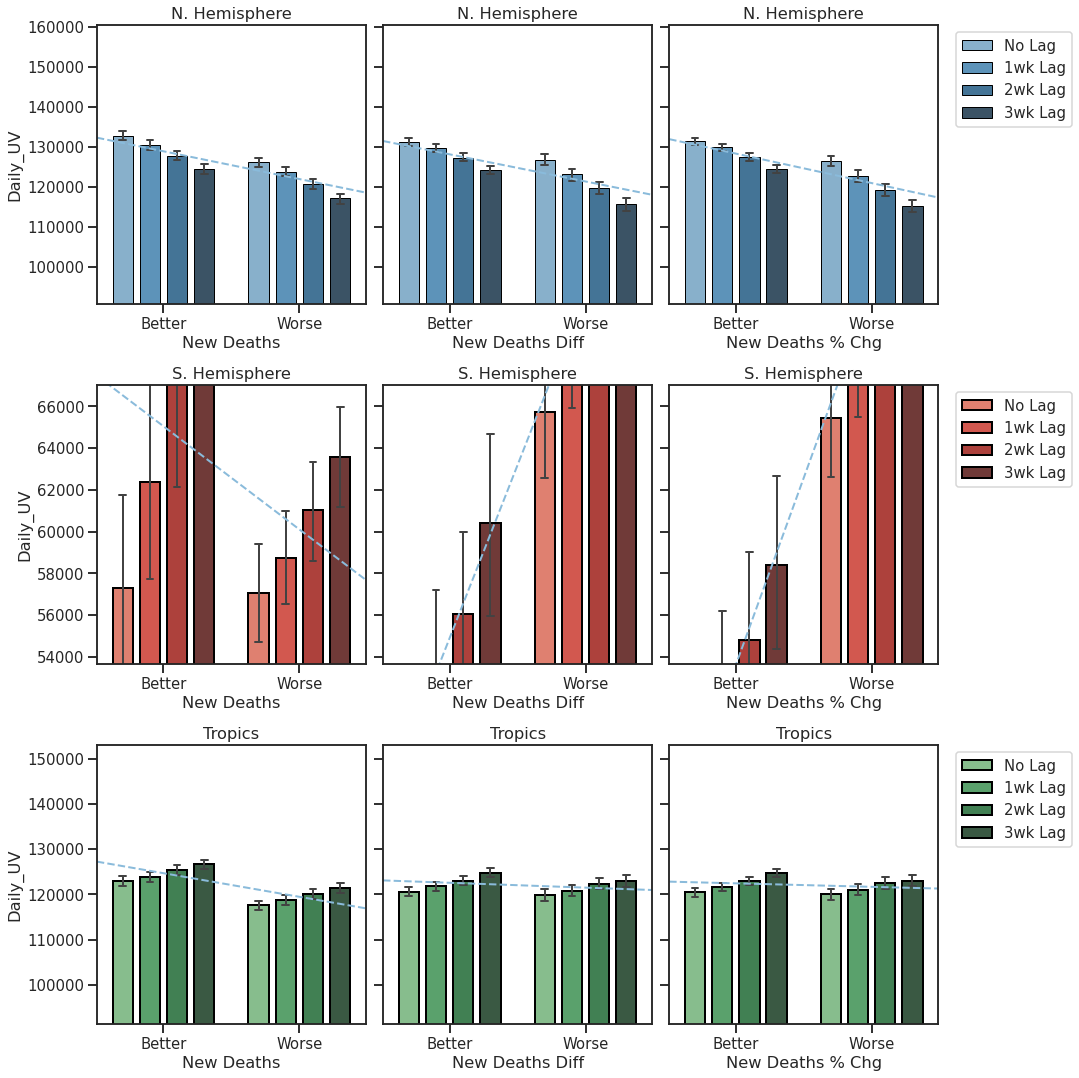

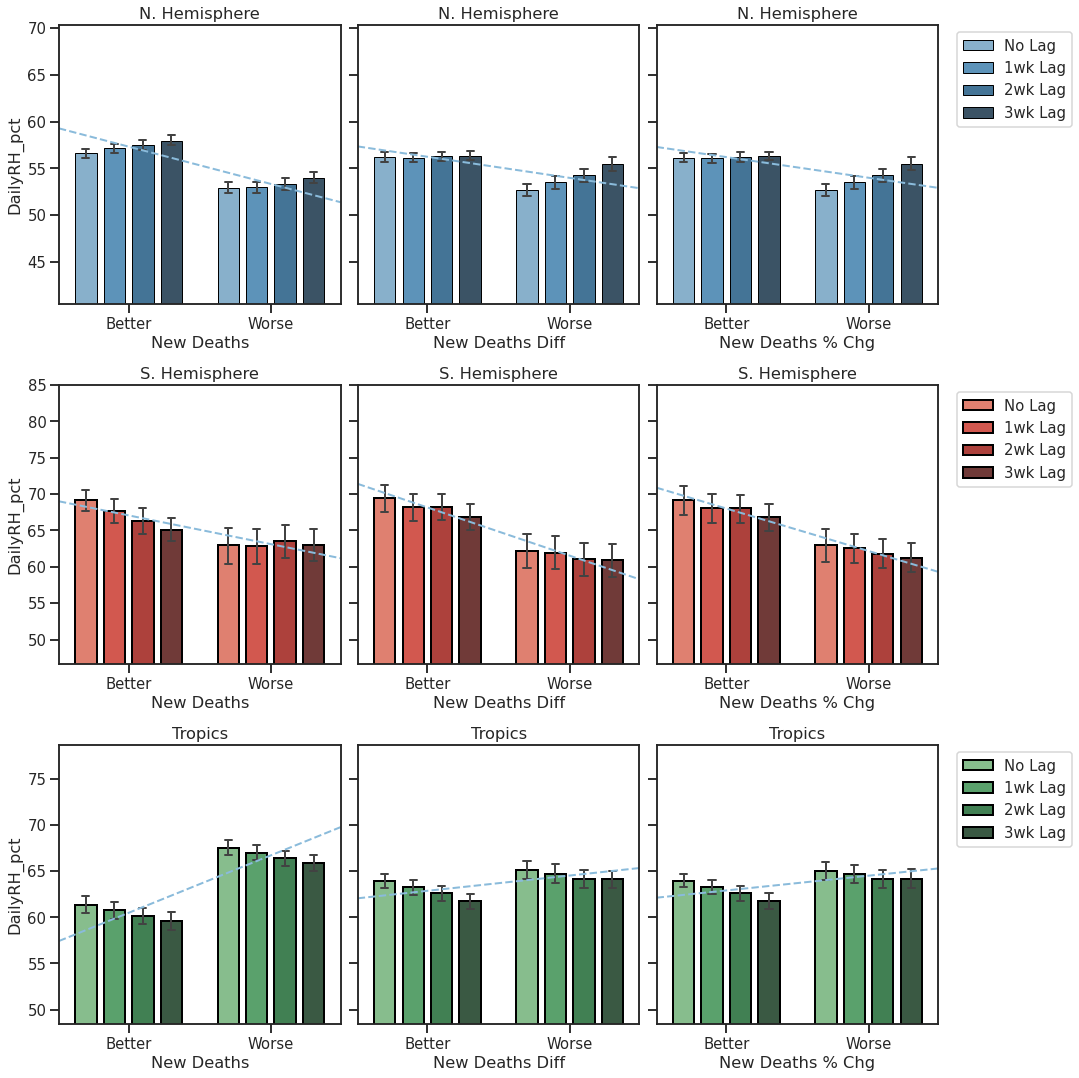

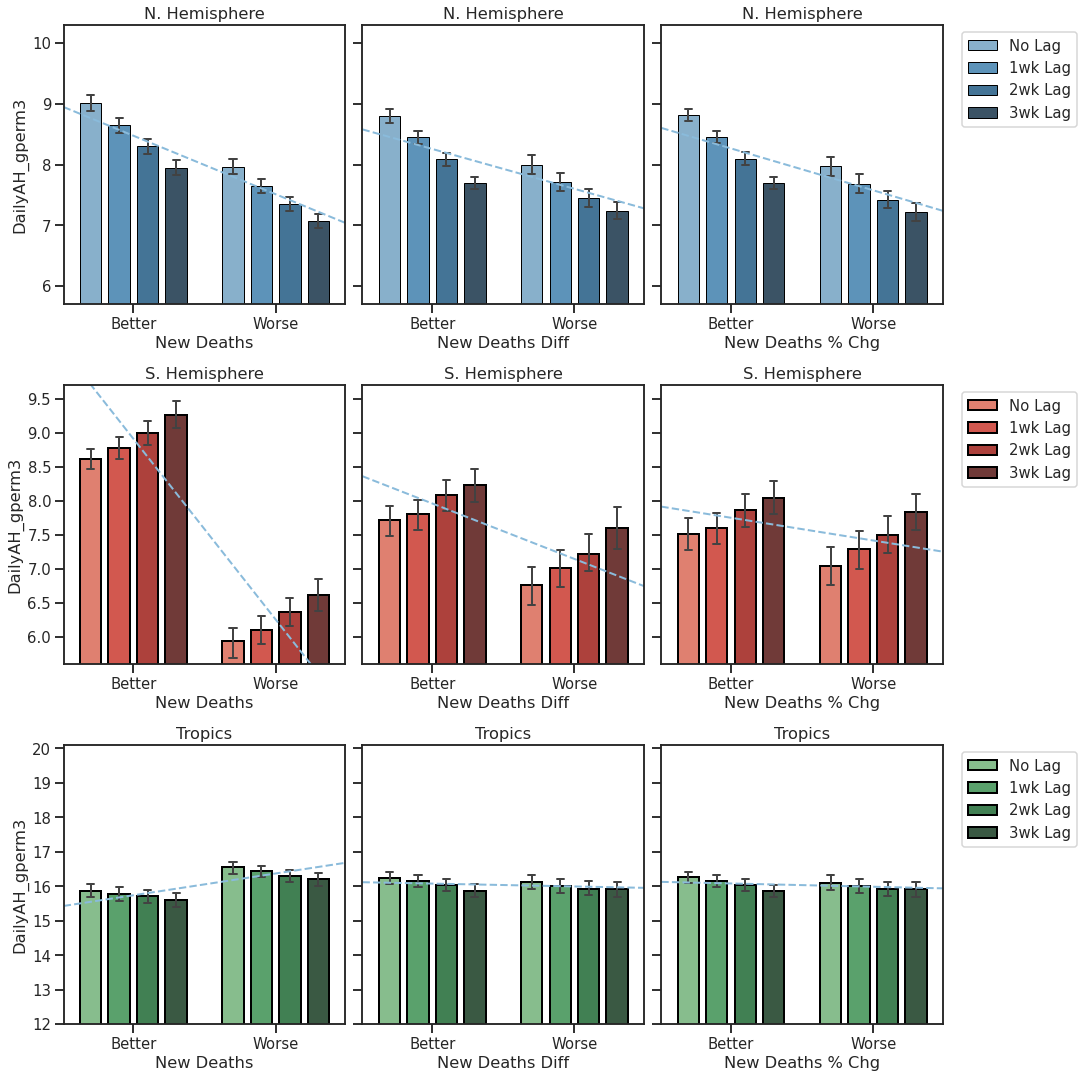

In [ ]:

for df7all_lag_VARIABLE in lagged_other_weather_vars:

  first_day = 0; last_day = 120; qlevels = 2; # Parameters for quantizing the dataset 
  qnhem = quantizer(dataframe=df7all_lag_VARIABLE, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=n_hem['Country'].unique(), retbins=False) # quantize the N. Hem outbreaks 
  qshem = quantizer(dataframe=df7all_lag_VARIABLE, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=s_hem['Country'].unique(), retbins=False) # quantize the S. Hem outbreaks 
  qtrop = quantizer(dataframe=df7all_lag_VARIABLE, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=trop['Country'].unique(), retbins=False) # quantize the Trop outbreaks 


  # Set up the plotting 
  quantized_outcomes = ['new_deaths_Qlevels','new_deaths_diff_Qlevels','new_deaths_pctchange_Qlevels']
  rows = 3; cols = len(quantized_outcomes); fig,ax=plt.subplots(rows,cols,figsize=(15,15),sharey='row')

  # Go through each quantized outbreak metric and make plots 
  for col in range(0,cols): 

    # Northern hemisphere colored bar plots and best fit 
    meltnhem = pd.melt(qnhem, id_vars=quantized_outcomes[col], value_vars=[qnhem.columns[2],qnhem.columns[2]+'_lag7',qnhem.columns[2]+'_lag14',qnhem.columns[2]+'_lag21'])
    sns.barplot(x=quantized_outcomes[col], y='value', hue='variable', data=meltnhem,ax=ax[0,col],capsize=.05,errwidth=2,edgecolor='black',linewidth=1,palette=sns.color_palette(palette='Blues_d',n_colors=4))
    sns.regplot(x=np.arange(0,len(meltnhem[quantized_outcomes[col]].cat.categories)),y=meltnhem.groupby(quantized_outcomes[col])['value'].mean().values,ci=None,line_kws={'linestyle': '--','linewidth':2},scatter=False,ax=ax[0,col],truncate=False)

    # Southern hemisphere colored bar plots and best fit 
    meltshem = pd.melt(qshem, id_vars=quantized_outcomes[col], value_vars=[qshem.columns[2],qshem.columns[2]+'_lag7',qshem.columns[2]+'_lag14',qshem.columns[2]+'_lag21'])
    sns.barplot(x=quantized_outcomes[col], y='value', hue='variable', data=meltshem,ax=ax[1,col],capsize=.05,errwidth=2,edgecolor='black',linewidth=2,palette=sns.color_palette(palette='Reds_d',n_colors=4))
    sns.regplot(x=np.arange(0,len(meltshem[quantized_outcomes[col]].cat.categories)),y=meltshem.groupby(quantized_outcomes[col])['value'].mean().values,ci=None,line_kws={'linestyle': '--','linewidth':2},scatter=False,ax=ax[1,col],truncate=False)

    # Tropical colored bar plots and best fit 
    melttrop = pd.melt(qtrop, id_vars=quantized_outcomes[col], value_vars=[qtrop.columns[2],qtrop.columns[2]+'_lag7',qtrop.columns[2]+'_lag14',qtrop.columns[2]+'_lag21'])
    sns.barplot(x=quantized_outcomes[col], y='value', hue='variable', data=melttrop,ax=ax[2,col],capsize=.05,errwidth=2,edgecolor='black',linewidth=2,palette=sns.color_palette(palette='Greens_d',n_colors=4))
    sns.regplot(x=np.arange(0,len(melttrop[quantized_outcomes[col]].cat.categories)),y=melttrop.groupby(quantized_outcomes[col])['value'].mean().values,ci=None,line_kws={'linestyle': '--','linewidth':2},scatter=False,ax=ax[2,col],truncate=False)

  # Define custom plotting legends 
  # Remove legends in the first 3 plots for all 3 rows 
  [ax[r,c].get_legend().remove() for r in np.arange(0,3) for c in np.arange(0,3)] 
  #[ax[r,c].get_legend().remove() for r in np.arange(0,1) for c in np.arange(0,3)] 


  # Get handles and labels information for the legend, then use these same handles and specify custom label names and custom label location in the subsequent line
  handles, labels = ax[0,2].get_legend_handles_labels(); ax[0,2].legend(handles, ['No Lag','1wk Lag','2wk Lag','3wk Lag'],bbox_to_anchor=(1.04,1), loc="upper left") # Rename the legend labels and place it outside of the figure
  handles, labels = ax[1,2].get_legend_handles_labels(); ax[1,2].legend(handles, ['No Lag','1wk Lag','2wk Lag','3wk Lag'],bbox_to_anchor=(1.04,1), loc="upper left") # Rename the legend labels and place it outside of the figure
  handles, labels = ax[2,2].get_legend_handles_labels(); ax[2,2].legend(handles, ['No Lag','1wk Lag','2wk Lag','3wk Lag'],bbox_to_anchor=(1.04,1), loc="upper left") # Rename the legend labels and place it outside of the figure
  # handles, labels = ax[0,0].get_legend_handles_labels(); ax[0,0].legend(handles, ['0wk','1wk','2wk','3wk'],loc='upper right')
  # handles, labels = ax[1,0].get_legend_handles_labels(); ax[1,0].legend(handles, ['0wk','1wk','2wk','3wk'],loc='upper right')
  # handles, labels = ax[2,0].get_legend_handles_labels(); ax[2,0].legend(handles, ['0wk','1wk','2wk','3wk'],loc='upper left')


  # Define xlabels 
  [ax[r,0].set_xlabel('New Deaths') for r in np.arange(0,3)]; [ax[r,1].set_xlabel('New Deaths Diff') for r in np.arange(0,3)]
  [ax[r,2].set_xlabel('New Deaths % Chg') for r in np.arange(0,3)]; #[ax[r,3].set_xlabel('Quantiles: New Deaths % Change') for r in np.arange(0,4)]

  # Define ylabels 
  #[ax.set_ylabel('Indoor RH (%)') for ax in plt.gcf().axes]
  [ax[r,c].set_ylabel('') for r in np.arange(0,3) for c in np.arange(1,3)]
  ax[0,0].set_ylabel(qnhem.columns[2])
  ax[1,0].set_ylabel(qshem.columns[2])
  ax[2,0].set_ylabel(qtrop.columns[2])
  #[ax[r,0].set_ylabel('Indoor RH (%)') for r in np.arange(0,3)]

  # Define titles
  [ax[0,c].set_title('N. Hemisphere') for c in np.arange(0,3)]
  [ax[1,c].set_title('S. Hemisphere') for c in np.arange(0,3)]
  [ax[2,c].set_title('Tropics') for c in np.arange(0,3)]

  # Define ylims 
  [ax[0,c].set_ylim(round(meltnhem.groupby(quantized_outcomes[col])['value'].mean().values[1]*.75,1),round(meltnhem.groupby(quantized_outcomes[col])['value'].mean().values[0]*1.25,1)) for c in np.arange(0,3)]
  [ax[1,c].set_ylim(round(meltshem.groupby(quantized_outcomes[col])['value'].mean().values[1]*.75,1),round(meltshem.groupby(quantized_outcomes[col])['value'].mean().values[0]*1.25,1)) for c in np.arange(0,3)]
  [ax[2,c].set_ylim(round(melttrop.groupby(quantized_outcomes[col])['value'].mean().values[1]*.75,1),round(melttrop.groupby(quantized_outcomes[col])['value'].mean().values[0]*1.25,1)) for c in np.arange(0,3)]
  [ax.set_xticklabels(['Better','Worse']) for ax in plt.gcf().axes]

  [change_width(ax, 0.15) for ax in plt.gcf().axes]
  fig.tight_layout(pad=0.5,h_pad=1,w_pad=0.5)

In [ ]:
import statsmodels.api as sm

def oddsratio(dataset,outcome,treatment):
  
  data = dataset[[outcome,treatment]].copy() # Copy dataset 

  contig_table = pd.crosstab(data[outcome],data[treatment]).iloc[::-1,] # Make a 2x2 contingency table, 00 = Bad Outcome/No Treatment, 10 = Good Outcome/No Treatment, 01 = Bad Outcome/Treatment, 11 = Good Outcome/Treatment 
  #print(contig_table)

  table = sm.stats.Table2x2(np.asarray(contig_table)) # Use statsmodels to turn the contingency table into a special 2x2 table for further statsmodels calculations 
  #print(table)

  #table=sm.stats.Table2x2.from_data(data) # Make a contingency table, 00 = Bad Outcome/No Treatment, 10 = Good Outcome/No Treatment, 01 = Bad Outcome/Treatment, 11 = Good Outcome/Treatment 

  odds_badoutcome_notreatment = contig_table.iloc[0,0]/contig_table.iloc[1,0] # Odds of having a worse outcome (e.g. more deaths) WITHOUT treatment (e.g. RH<40% or RH>60%) 
  odds_badoutcome_withtreatment = contig_table.iloc[0,1]/contig_table.iloc[1,1] # Odds of having a worse outcome (e.g. more deaths) WITH treatment (e.g. RH 40%-60%) 

  odds_ratio = table.oddsratio # Odds ratio (ratio of odds_badoutcome_notreatment to odds_badoutcome_withtreatment) -> how much more likely are you to have a bad outcome if you don't receive the treatment 
  LCB = table.oddsratio_confint()[0] # Lower 95% confidence boundary
  UCB = table.oddsratio_confint()[1] # Upper 95% confidence boundary 
  pval = table.oddsratio_pvalue() # p-value for a hypothesis test about the odds ratio

  return odds_badoutcome_notreatment, odds_badoutcome_withtreatment, odds_ratio, LCB, UCB, pval 

# To run function... 
# oddsratio(dataset=treat_total,outcome='new_cases_Qlevels',treatment='quantized_IndRH')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in long_scalars
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in long_scalars
  app.launch_new_instance()


Done
Done
Done


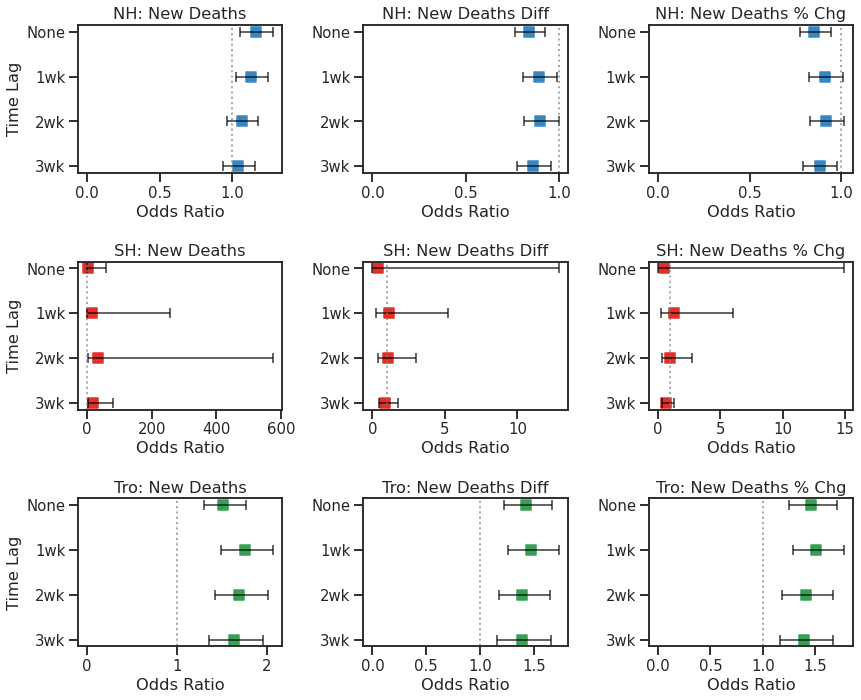

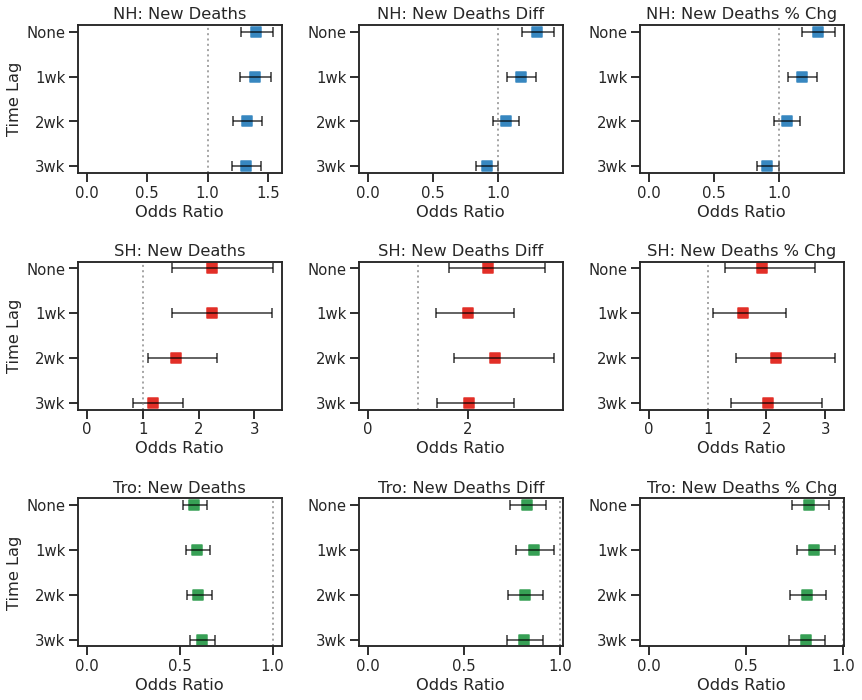

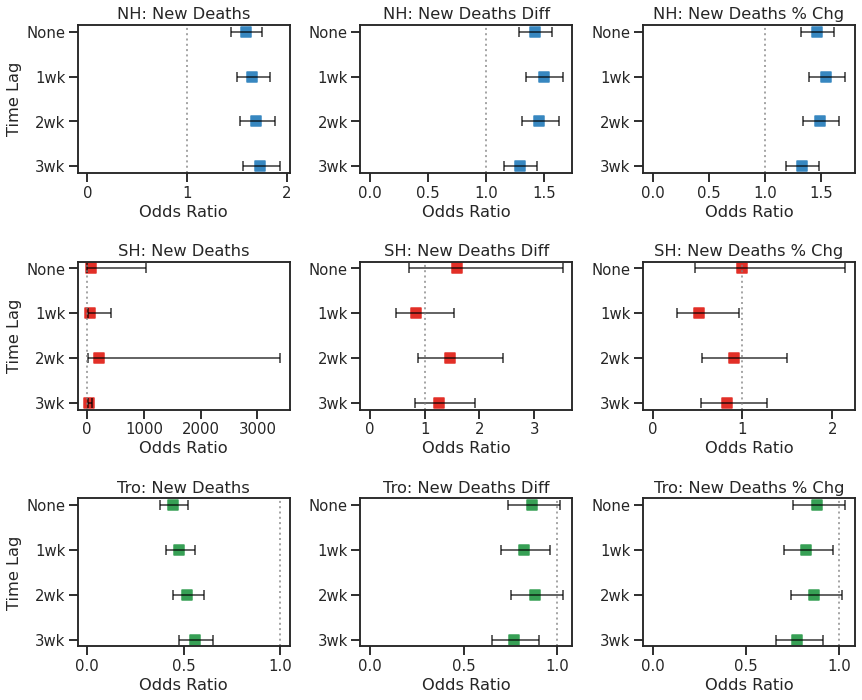

In [ ]:
# List of lagged dataframes with other weather variables to look at... 
lagged_other_weather_vars2 = [df7all_lag_temp,df7all_lag_RH,df7all_lag_AH] # Drop uv cuz you don't have any 1's in the southern hemisphere, apparently they don't get very much UV? 

# Note -> When you break the treatment variables at the median, there are no 1's present in the southern hemisphere for the UV metric (apparently they don't get enough sunshine). So if you want to get the ORs for just the NH and Trop regions then you have to uncomment the commented lines 

for df7all_lag_VARIABLE in lagged_other_weather_vars2:
#for df7all_lag_VARIABLE in lagged_other_weather_vars:

  treatment_qlevels = 2
  # Discretize the treatment  
  df7all_lag_VARIABLE['quantized_IndRH'] = pd.qcut(df7all_lag_VARIABLE[df7all_lag_VARIABLE.columns[2]],q=treatment_qlevels,labels=False) # Use qcut to break up the continuous data 
  df7all_lag_VARIABLE['quantized_IndRH_lag7'] = pd.qcut(df7all_lag_VARIABLE[df7all_lag_VARIABLE.columns[2]+'_lag7'],q=treatment_qlevels,labels=False) # Use qcut to break up the continuous data 
  df7all_lag_VARIABLE['quantized_IndRH_lag14'] = pd.qcut(df7all_lag_VARIABLE[df7all_lag_VARIABLE.columns[2]+'_lag14'],q=treatment_qlevels,labels=False) # Use qcut to break up the continuous data 
  df7all_lag_VARIABLE['quantized_IndRH_lag21'] = pd.qcut(df7all_lag_VARIABLE[df7all_lag_VARIABLE.columns[2]+'_lag21'],q=treatment_qlevels,labels=False) # Use qcut to break up the continuous data 

  # Binarize the treatment (so <40 and >60 are untreated, 40-60 are treated) -> don't need to do this, already binarized (since you split at the median with qcut) 
  binary_treatment = df7all_lag_VARIABLE.copy()
  #binary_treatment.loc[:,['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']] = binary_treatment.loc[:,['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']].replace(2,0)

  # Compute odds ratios by region (All Countries, NH, SH, Trop) 
  first_day = 0; last_day = 120; qlevels=2
  treat_nhem = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=n_hem['Country'].unique(), retbins=False).dropna()
  treat_shem = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=s_hem['Country'].unique(), retbins=False).dropna()
  treat_trop = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=trop['Country'].unique(), retbins=False).dropna()


  quantized_outcomes = ['new_cases_Qlevels','new_deaths_Qlevels','new_deaths_diff_Qlevels','new_deaths_pctchange_Qlevels']
  quantized_humidities = ['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']
  dataset_list = [treat_nhem, treat_shem, treat_trop]
  #dataset_list = [treat_nhem, treat_trop]
  dataset_names = ['NH','SH','Tro']
  #dataset_names = ['NH','Tro']



  level3 = []
  for outcome in quantized_outcomes: 

    level2 = []
    for humidity in quantized_humidities: 

      
      level1 = [] # Empty list to store each output from the primary calculations

      for dset in dataset_list: 

        computeOR = oddsratio(dataset=dset,outcome=outcome,treatment=humidity) # Compute the odds for NO treatment odds for WITH treatment, odds ratio, LCL, UCL, and pval

        level1.append(computeOR) # Append the output tuple to the list 

      df_level1 = pd.DataFrame(level1, columns =['oddsbad_NO_treatment', 'oddsbad_WITH_treatment', 'odds_ratio','LCL','UCL','pval'],index=dataset_names) # Put all outputs into a labeled dataframe

      level2.append(df_level1) # Put the labeled output dataframe (calculations for each region) into the list of dataframes in level 2 (calculations for each time-lagged humidity value) 
    
    df_level2 = pd.concat(level2,keys=quantized_humidities) # Put all dfs into a multi-index dataframe 

    level3.append(df_level2) # Put the multi-index dataframes (calcs for each region and each time-lag) into the list of dataframes in level 3(calculations for each COVID-19 outbreak metric) 

  df_ORs_byregion = pd.concat(level3, keys=quantized_outcomes) # Put all of the multi-index dataframes into a final multi-index dataframe 

  print('Done')

  # Set up the plotting 
  quantized_outcomes = ['new_deaths_Qlevels','new_deaths_diff_Qlevels','new_deaths_pctchange_Qlevels']
  quantized_humidities = ['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']
  dataset_names = ['NH','SH','Tro']
  #dataset_names = ['NH','Tro']


  rows = len(dataset_names); cols = len(quantized_outcomes); fig,ax=plt.subplots(rows,cols,figsize=(12,9.75))

  points = []; lines=[]
  # Go through each quantized outbreak metric and make plots 
  for col in range(0,cols):
    for lag in range(len(quantized_humidities)):
      for region in range(len(dataset_names)):

        data_for_plotting = df_ORs_byregion.loc[(quantized_outcomes[col],quantized_humidities[lag],dataset_names[region])]
        ax[region,col].errorbar(x=data_for_plotting['odds_ratio'],y=lag,xerr=np.array([data_for_plotting['odds_ratio']-data_for_plotting['LCL'],data_for_plotting['UCL']-data_for_plotting['odds_ratio']]).reshape(-1,1),capsize=5,capthick=2,elinewidth=2,ecolor='k',alpha=0.6,dash_capstyle='butt')
        points.append(ax[region,col].scatter(data_for_plotting['odds_ratio'],lag,marker='s',color='k',alpha=1,s=120))
        ax[region,col].set_yticks(range(0,len(quantized_humidities)))
        ax[region,col].set_yticklabels(['None','1wk','2wk','3wk'])

  ax[0,0].set_title('NH: New Deaths')
  ax[1,0].set_title('SH: New Deaths')
  ax[2,0].set_title('Tro: New Deaths')

  ax[0,1].set_title('NH: New Deaths Diff')
  ax[1,1].set_title('SH: New Deaths Diff')
  ax[2,1].set_title('Tro: New Deaths Diff')

  ax[0,2].set_title('NH: New Deaths % Chg')
  ax[1,2].set_title('SH: New Deaths % Chg')
  ax[2,2].set_title('Tro: New Deaths % Chg')

  [ax.set_xlabel('Odds Ratio') for ax in plt.gcf().axes]
  [ax[r,0].set_ylabel('Time Lag') for r in np.arange(0,3)]

  [points[i].set_color(sns.color_palette(palette='Blues_d',n_colors=1)) for i in range(0,36,3)]
  [points[i].set_color(sns.color_palette(palette='Reds_d',n_colors=1)) for i in range(1,37,3)]
  [points[i].set_color(sns.color_palette(palette='Greens_d',n_colors=1)) for i in range(2,38,3)]

  # ax[0,0].set_title('NH: New Deaths')
  # ax[1,0].set_title('Trop: New Deaths')
  # ax[0,1].set_title('NH: New Deaths Diff')
  # ax[1,1].set_title('Trop: New Deaths Diff')
  # ax[0,2].set_title('NH: New Deaths % Chg')
  # ax[1,2].set_title('Trop: New Deaths % Chg')
  # [ax.set_xlabel('Odds Ratio') for ax in plt.gcf().axes]
  # [ax[r,0].set_ylabel('Time Lag') for r in np.arange(0,2)]
  # [points[i].set_color(sns.color_palette(palette='Blues_d',n_colors=1)) for i in range(0,24,2)]
  # [points[i].set_color(sns.color_palette(palette='Greens_d',n_colors=1)) for i in range(1,25,2)]

  [ax.axvline(x=0,color='grey',alpha=0.0,linewidth=0) for ax in plt.gcf().axes]
  [ax.axvline(x=1,linestyle=':',color='grey',alpha=0.7,linewidth=2) for ax in plt.gcf().axes]
  [ax.invert_yaxis() for ax in plt.gcf().axes]
  fig.tight_layout(pad=0.5,h_pad=1.5,w_pad=1)